# Generative Adversarial Networks

We then study the possibility to generate the favourable embedding from the non favourable embedding from the non favourable ones.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf

# reset everything
tf.keras.backend.clear_session()

# set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
import numpy as np
import tensorflow as tf

RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

## Load the Dataset

We load the full dataset and prepare it for a convolutional network.

In [4]:
import pandas as pd

df = pd.read_csv('./data/full.csv')
df = df.sample(frac=1, random_state=RAND)

# divide the old and favourable datasets
old = df.filter(regex='^old')
fav = df.filter(regex='^fav')

# reshape everything
old = old.values.reshape(-1, 12, 15, 1)
fav = fav.values.reshape(-1, 15, 18, 1)

In [5]:
# divide into training and development sets
train_size = 0.9
index      = int(train_size * df.shape[0])

old_train, old_test = old[:index], old[index:]
fav_train, fav_test = fav[:index], fav[index:]

Convert everything to tensorflow tensor:

In [6]:
import tensorflow as tf
from tensorflow import convert_to_tensor

old_train = convert_to_tensor(old_train, dtype=tf.float32)
old_test  = convert_to_tensor(old_test, dtype=tf.float32)
fav_train = convert_to_tensor(fav_train, dtype=tf.float32)
fav_test  = convert_to_tensor(fav_test, dtype=tf.float32)

## Prepare the Models

We then prepare the **generator** and **discriminator** models to train on the dataset.

### Generator

We first define and build the **generator** model:

In [7]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, \
                                    Conv2DTranspose, \
                                    LeakyReLU, \
                                    concatenate, \
                                    BatchNormalization, \
                                    Dropout, \
                                    GaussianNoise, \
                                    ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import glorot_uniform, zeros

def generator_model(filters=[10],
                    leaky=0.0,
                    kernel_size=[(2,2)],
                    batchnorm=0.99,
                    dropout=0.01,
                    l1_reg=0.0,
                    l2_reg=0.0,
                    noise=0.0,
                    random_state=42
                   ):
    
    # define the input layer
    I = Input(shape=old.shape[1:])
    x = I
    
    # define the kernel regularizer
    reg = l1_l2(l1=l1_reg, l2=l2_reg)
    
    # create the network
    for n in range(len(filters)):
        x = Conv2DTranspose(filters[n],
                            kernel_size=kernel_size[n],
                            padding='same',
                            kernel_regularizer=reg,
                            kernel_initializer=glorot_uniform(random_state),
                            bias_initializer=zeros()
                           )(x)
        x = LeakyReLU(alpha=leaky)(x)
        
        # upsample the image
        if x.shape[1:-1] != fav.shape[1:-1]:
            x = ZeroPadding2D(padding=((0,1), (0,1)), data_format='channels_last')(x)
        
        if batchnorm > 0.0:
            x = BatchNormalization(momentum=batchnorm)(x)
        if dropout > 0.0:
            x = Dropout(rate=dropout, seed=random_state)(x)
    
    # reduce everything to a single filter
    x = Conv2DTranspose(1,
                        kernel_size=(1,1),
                        activation='relu',
                        padding='same',
                        kernel_regularizer=reg,
                        kernel_initializer=glorot_uniform(random_state),
                        bias_initializer=zeros()
                       )(x)
            
    # define the model
    model = Model(inputs=I, outputs=x, name='generator')
    
    return model

We then build the model and display its properties:

In [8]:
generator = generator_model(filters=[256, 256, 128, 128, 64, 64, 32, 32, 16, 16],
                            kernel_size=[(5,5), (5,5), (5,5), (5,5), (5,5), (5,5), (3,3), (3,3), (3,3), (3,3)],
                            leaky=0.3,
                            dropout=0.05,
                            l1_reg=1.0e-4,
                            l2_reg=1.0e-4,
                            noise=0.1,
                            random_state=RAND
                           )

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 15, 1)]       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 15, 256)       6656      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12, 15, 256)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 13, 16, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 16, 256)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 13, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 16, 256)       16

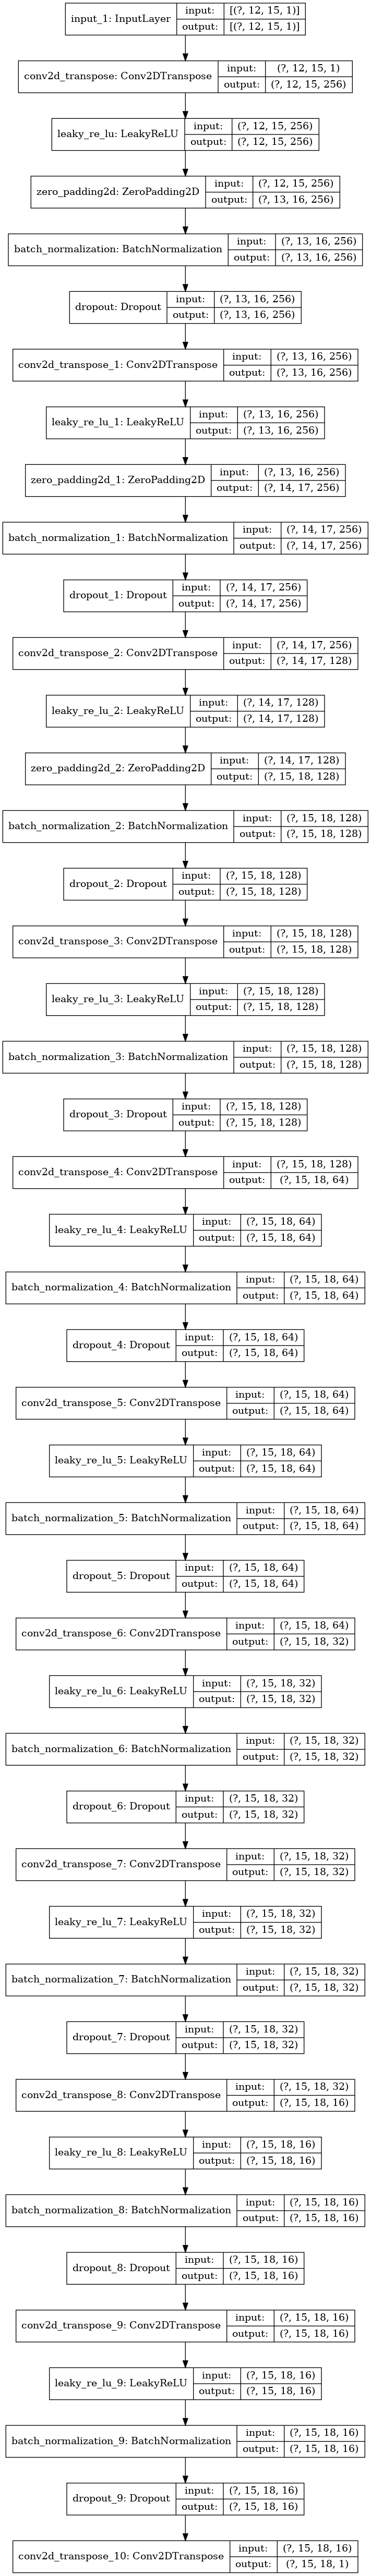

In [10]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(generator, show_shapes=True)
Image(dot.create_png(), width=480)

### Discriminator

We then build the discriminator network which should decide whether the input is real or fake.

In [11]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, \
                                    Conv2D, \
                                    Dense, \
                                    LeakyReLU, \
                                    concatenate, \
                                    Flatten, \
                                    BatchNormalization, \
                                    Dropout, \
                                    GaussianNoise
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import glorot_uniform, zeros

def discriminator_model(filters=[10],
                        units=[],
                        leaky=0.0,
                        batchnorm=0.99,
                        dropout=0.01,
                        l1_reg=0.0,
                        l2_reg=0.0,
                        noise=0.0,
                        random_state=42
                       ):
    
    # define the input layer
    I = Input(shape=fav.shape[1:])
    x = I
    
    # define the kernel regularizer
    reg = l1_l2(l1=l1_reg, l2=l2_reg)
    
    # add a bit of noise
    if noise > 0.0:
        x = GaussianNoise(stddev=noise)(x)
    
    # create the network
    for n in range(len(filters)):
        a = Conv2D(filters[n],
                   kernel_size=(x.shape[1], 1),
                   padding='same',
                   kernel_regularizer=reg,
                   kernel_initializer=glorot_uniform(random_state),
                   bias_initializer=zeros()
                   )(x)
        a = LeakyReLU(alpha=leaky)(a)
        
        b = Conv2D(filters[n],
                   kernel_size=(1, x.shape[2]),
                   padding='same',
                   kernel_regularizer=reg,
                   kernel_initializer=glorot_uniform(random_state),
                   bias_initializer=zeros()
                   )(x)
        b = LeakyReLU(alpha=leaky)(b)
        
        x = concatenate([a, b])
        
        if batchnorm > 0.0:
            x = BatchNormalization(momentum=batchnorm)(x)
            
    # add dropout
    if dropout > 0.0:
        x = Dropout(rate=dropout, seed=random_state)(x)
        
    # flatten the output
    x = Flatten()(x)
    
    # fully connected network
    for n in range(len(units)):
        x = Dense(units[n],
                  kernel_regularizer=reg,
                  kernel_initializer=glorot_uniform(random_state),
                  bias_initializer=zeros()
                 )(x)
        x = LeakyReLU(alpha=leaky)(x)
        
        if batchnorm > 0.0:
            x = BatchNormalization(momentum=batchnorm)(x)
            
        if dropout > 0.0:
            x = Dropout(rate=dropout, seed=random_state)(x)
        
    # output
    x = Dense(1,
              activation='sigmoid',
              kernel_initializer=glorot_uniform(random_state),
              bias_initializer=zeros()
             )(x)
            
    # define the model
    model = Model(inputs=I, outputs=x, name='discriminator')
    
    return model

We then build the model and display its properties:

In [12]:
discriminator = discriminator_model(filters=[128, 128, 64, 64, 32, 32, 16, 16],
                                    units=[100, 10],
                                    leaky=0.3,
                                    dropout=0.05,
                                    l1_reg=1.0e-4,
                                    l2_reg=1.0e-4,
                                    noise=0.1,
                                    random_state=RAND
                                   )

In [13]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 18, 1)]  0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 15, 18, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 18, 128)  2048        gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 18, 128)  2432        gaussian_noise[0][0]             
______________________________________________________________________________________

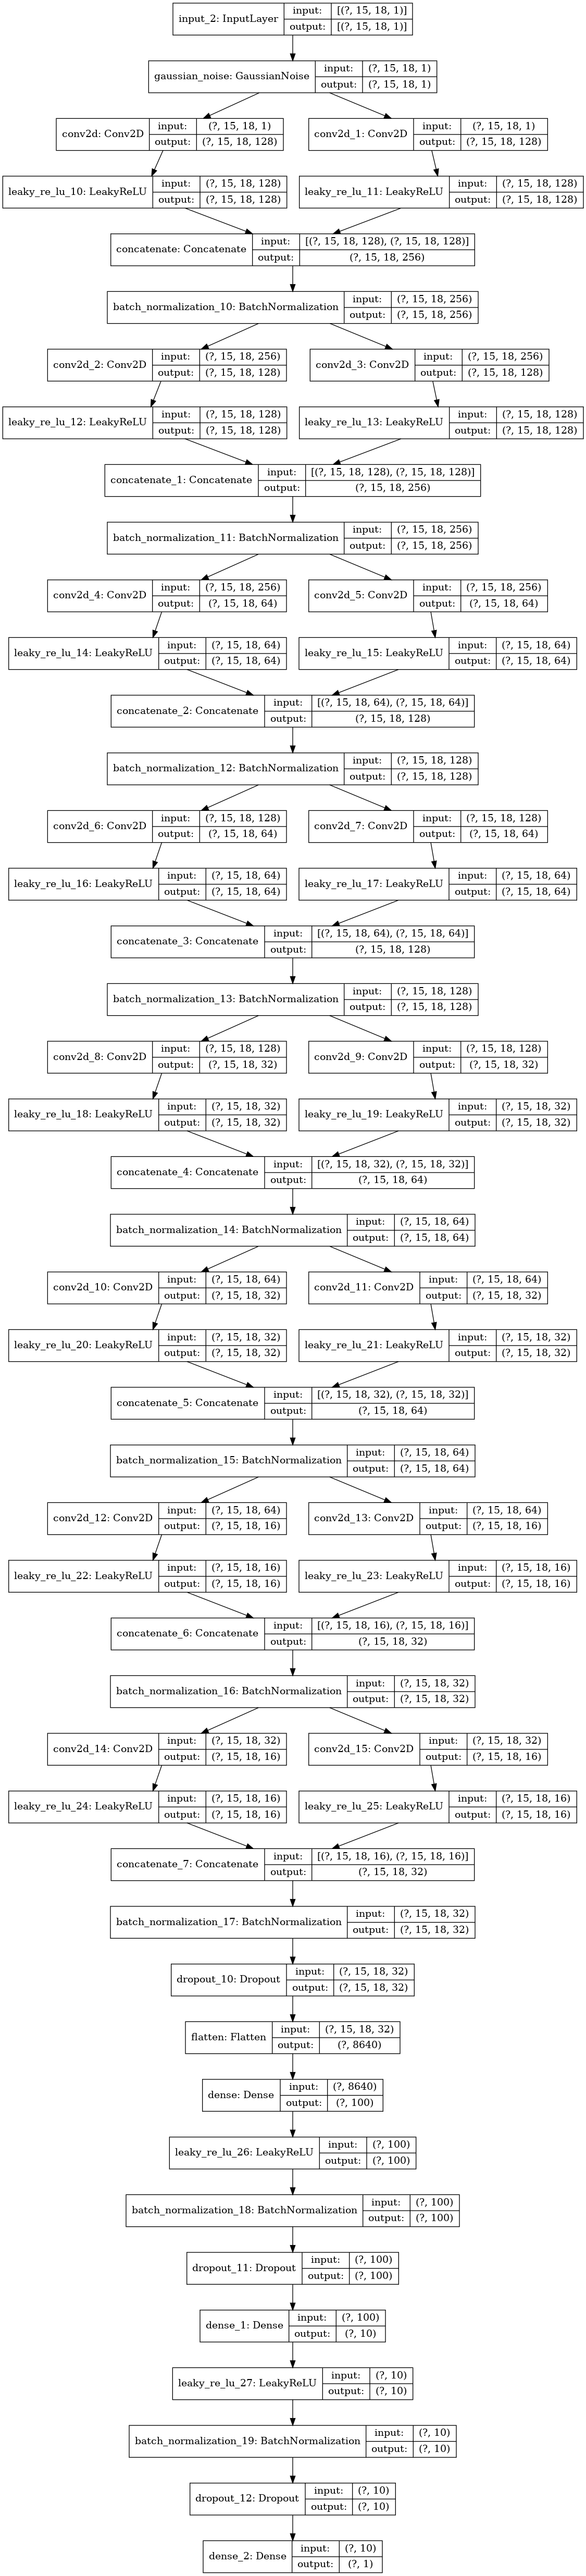

In [14]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

dot = model_to_dot(discriminator, show_shapes=True)
Image(dot.create_png(), width=480)

### Losses and Gradient Descent

We then define the losses of the generator and discriminator models.

In [15]:
from tensorflow import ones_like, zeros_like
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import uniform
from tensorflow import shape

cross_entropy = BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(fake):
    
    # compute cross entropy (how well a fake is close to a real image)
    return cross_entropy(zeros_like(fake), fake)

In [17]:
def discriminator_loss(real, fake):
    
    # apply some random noise to the labels
    real += 0.05 * uniform(shape(real))
    fake += 0.05 * uniform(shape(fake))
    
    # compute cross entropy (array of 0 for real, array of 1 for fake)
    real_loss = cross_entropy(zeros_like(real), real)
    fake_loss = cross_entropy(ones_like(fake), fake)
    
    return real_loss + fake_loss

In [18]:
from tensorflow.keras.optimizers import Adam

generator_optimizer     = Adam(1.0e-5)
discriminator_optimizer = Adam(1.0e-5)

### Checkpoints

We also prepare a callback to save the checkpoints.

In [19]:
from os import makedirs
from os.path import join
from tensorflow.train import Checkpoint

# create the directory
makedirs('./checkpoints', exist_ok=True)
checkpoint_dir = './checkpoints'
checkpoint_prefix = join(checkpoint_dir, "checkpoint")

# create the checkpoint
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                        discriminator_optimizer=discriminator_optimizer,
                        generator=generator,
                        discriminator=discriminator
                       )

### Training

We then move towards training the **DCGAN**.

In [20]:
import numpy as np

EPOCHS     = 5000
BATCH_SIZE = 64

In [21]:
from tensorflow import GradientTape
from tensorflow import function

@function
def train_steps(old, fav):
    
    with GradientTape() as generator_tape, GradientTape() as discriminator_tape:
        
        # generate new matrices
        gen_fav = generator(old, training=True)
        
        # classify real and fake outputs
        real = discriminator(fav, training=True)
        fake = discriminator(gen_fav, training=True)
        
        # compute the loss
        gen_loss = generator_loss(fake)
        dis_loss = discriminator_loss(real, fake)
        
    # compute the gradients
    gen_grad = generator_tape.gradient(gen_loss, generator.trainable_weights)
    dis_grad = discriminator_tape.gradient(dis_loss, discriminator.trainable_weights)
    
    # compute the gradient descent
    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_weights))
    discriminator_optimizer.apply_gradients(zip(dis_grad, discriminator.trainable_weights))
    
    # return the losses
    return gen_loss, dis_loss

In [22]:
import time
from tensorflow.data import Dataset

old_train = Dataset.from_tensor_slices(old_train).batch(BATCH_SIZE).prefetch(BATCH_SIZE)
fav_train = Dataset.from_tensor_slices(fav_train).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [23]:
import numpy as np
import tensorflow as tf
from tqdm import trange

def train(old, fav):
        
    start = time.time()
    
    # loss series
    metric_dict     = {'generator loss': [],
                       'discriminator loss': [],
                       'accuracy': []
                      }

    with trange(EPOCHS, desc='Training epochs', unit='epoch') as pbar:
        
        for epoch in pbar:

            gen_loss_epoch  = []
            dis_loss_epoch  = []

            for old_batch, fav_batch in zip(old, fav):
                gen_loss, disc_loss = train_steps(old_batch, fav_batch)
                gen_loss_epoch.append(float(gen_loss))
                dis_loss_epoch.append(float(disc_loss))

            elapsed = time.time() - start

            # compute and save the average losses
            gen_loss_avg = np.mean(gen_loss_epoch)
            dis_loss_avg = np.mean(dis_loss_epoch)

            # compute the mean squared error on the test set
            fav_test_pred = tf.math.rint(generator(old_test))
            #diff = tf.math.reduce_mean(tf.square(tf.subtract(fav_test_pred, fav_test))).numpy()
            acc = float(tf.math.reduce_sum(tf.cast(tf.math.equal(fav_test_pred, fav_test), dtype=tf.float32)))
            acc = acc / np.prod(fav_test.shape)

            # update the dictionary
            metric_dict['generator loss'].append(gen_loss_avg)
            metric_dict['discriminator loss'].append(dis_loss_avg)
            metric_dict['accuracy'].append(acc)
            pbar.set_postfix({'generator loss': gen_loss_avg,
                              'discriminator loss': dis_loss_avg,
                              'accuracy': acc
                             }
                            )
            
    return metric_dict

We finally train the model:

In [24]:
metrics = train(old_train, fav_train)

Training epochs:  38%|███▊      | 1880/5000 [5:21:06<8:52:36, 10.24s/epoch, generator loss=1.3, discriminator loss=1.03, accuracy=0.817]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



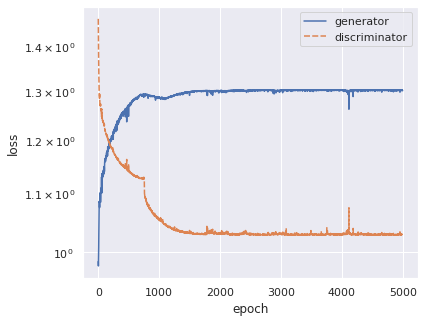

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os import makedirs
sns.set()

# create dataframe
losses = pd.DataFrame({'generator': metrics['generator loss'],
                       'discriminator': metrics['discriminator loss']}
                     )

# plot the dataframe
_, ax = plt.subplots(figsize=(6,5))

sns.lineplot(data=losses,
             ci=False,
             ax=ax
            )
ax.set(title='',
       xlabel='epoch',
       ylabel='loss',
       yscale='log'
      )

makedirs('./img', exist_ok=True)
plt.savefig('./img/dcgan_loss.pdf', dpi=150, format='pdf')
plt.savefig('./img/dcgan_loss.png', dpi=150, format='png')

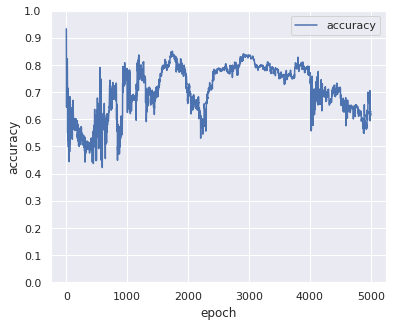

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import makedirs
sns.set()

# create dataframe
acc = pd.DataFrame({'accuracy': metrics['accuracy']})

# plot the dataframe
_, ax = plt.subplots(figsize=(6,5))

sns.lineplot(data=acc,
             ci=False,
             ax=ax
            )
ax.set(title='',
       xlabel='epoch',
       ylabel='accuracy',
       yticks=np.arange(0.0, 1.1, 0.1)
      )

makedirs('./img', exist_ok=True)
plt.savefig('./img/dcgan_acc.pdf', dpi=150, format='pdf')
plt.savefig('./img/dcgan_acc.png', dpi=150, format='png')

Finally we perform the predictions on the test set:

In [27]:
# compute the predictions
fav_test_pred = generator(old_test).numpy()

# compute the squared difference
diff = tf.math.reduce_mean(tf.square(tf.subtract(fav_test_pred, fav_test))).numpy()
print(f'Average squared difference: {diff:.2f}')

Average squared difference: 2.45


We can also print some of them:

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

rows = 20
cols = 3

In [29]:
old_test      = old_test.numpy().reshape(-1, 12, 15)
fav_test_pred = np.rint(fav_test_pred.reshape(-1, 15, 18))
fav_test      = fav_test.numpy().reshape(-1, 15, 18)

index = np.random.choice(fav_test.shape[0], rows)

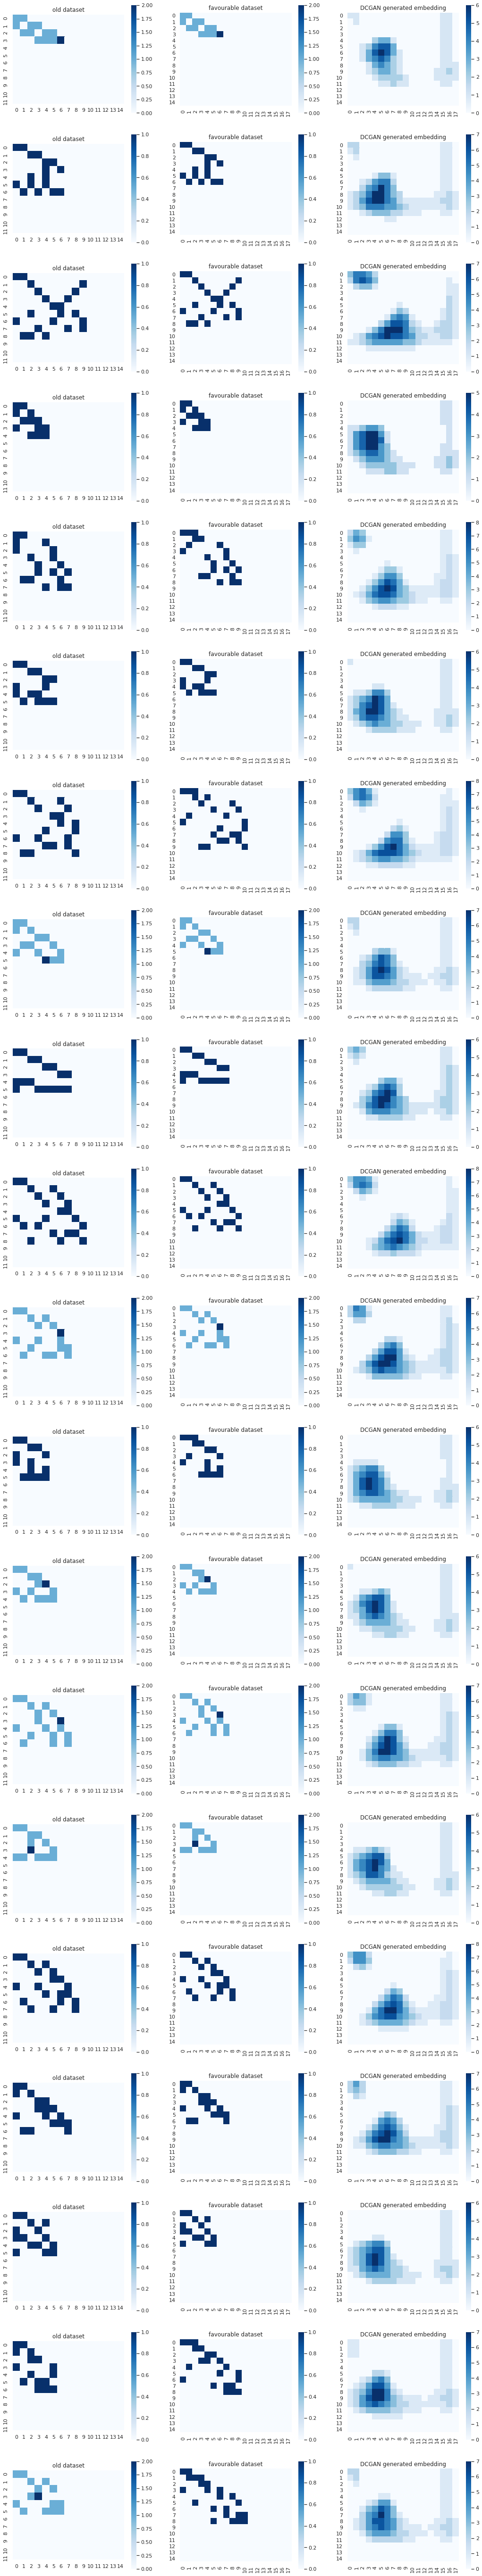

In [30]:
from os import makedirs

_, ax = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

for i, mat in enumerate(zip(old_test[index], fav_test[index], fav_test_pred[index])):
    
    sns.heatmap(mat[0],
                cmap='Blues',
                square=True,
                ax=ax[i,0]
               )
    ax[i,0].set(title='old dataset')
    sns.heatmap(mat[1],
                cmap='Blues',
                square=True,
                ax=ax[i,1]
               )
    ax[i,1].set(title='favourable dataset')
    sns.heatmap(mat[2],
                cmap='Blues',
                square=True,
                ax=ax[i,2]
               )
    ax[i,2].set(title='DCGAN generated embedding')
    
makedirs('./img', exist_ok=True)
plt.savefig('./img/dcgan_comparison.pdf', dpi=150, format='pdf')
plt.savefig('./img/dcgan_comparison.png', dpi=150, format='png')